In [13]:
from sklearn import datasets, linear_model, preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from file_reader import read_file
from math import sqrt
import random


In [14]:
class MultiClassLogisticRegression:

    def __init__(self, X, y, random_seed=22):
        np.random.seed(random_seed)
        self.random_seed = random_seed
        self.loss = []
        self.classes = np.unique(y)
        self.class_labels = {c: i for i, c in enumerate(self.classes)}
        self.w = np.random.rand(len(self.classes), X.shape[1])
        self.y_true = self.one_hot_encoding(y)
        self.epsilon = 1e-10

    def one_hot_encoding(self, y):
        return np.eye(len(self.classes))[np.vectorize(lambda c: self.class_labels[c])(y).reshape(-1)]

    def predict(self, X, w):
        return np.array([self.softmax(x, w) for x in X])

    def softmax(self, X, w):
        z = np.dot(X, w.T)
        max_z = np.max(z)
        exp_z = np.exp(z - max_z)  # Subtract the maximum value for numerical stability
        return exp_z / np.sum(exp_z)

    def cross_entropy_loss(self, probs, w, lam):
        N = self.y_true.shape[0]
        l2 = 1 / 2 * lam * np.linalg.norm(w) ** 2
        clipped_probs = np.clip(probs, self.epsilon, 1 - self.epsilon)
        return l2 + (-1 / N * np.sum(self.y_true * np.log(clipped_probs)))

    def cross_entropy_loss_gradient(self, X, probs, w, lam):
        return np.dot((probs - self.y_true).T, X) / X.shape[0] + lam * np.linalg.norm(w)

    def cross_entropy_hessian(self, X, lam):
        n_samples, n_features = X.shape
        n_classes = self.w.shape[0]
        probs = self.predict(X, self.w)
        H = np.zeros((n_features, n_features))

        for n in range(n_samples):
            p_n = probs[n]
            x_n = X[n]
            for i in range(n_classes):
                H += np.outer(x_n, x_n) * (p_n[i] - p_n[i] * p_n[i])

        return H / n_samples + lam

    def predict_classes(self, X):
        probs = self.predict(X, self.w)
        return np.vectorize(lambda c: self.classes[c])(np.argmax(probs, axis=1))

    def score(self, X, y):
        return np.mean(self.predict_classes(X) == y)

    def armijo_line_search(self, X, G, direction, current_loss, alpha, rho, c, lam):
        while alpha > 1e-8:
            new_w = self.w + alpha * direction
            new_probs = self.predict(X, new_w)
            new_loss = self.cross_entropy_loss(new_probs, new_w, lam)
            if new_loss <= current_loss + c * alpha * np.linalg.norm(np.dot(G.T, direction)):
                return alpha

            alpha *= rho

        return alpha

    def gradient_descend(self, X, max_epoch, alpha, rho, c, lam):
        prev_loss = float('inf')
        for i in range(max_epoch):
            probs = self.predict(X, self.w)
            loss = self.cross_entropy_loss(probs, self.w, lam)
            G = self.cross_entropy_loss_gradient(X, probs, self.w, lam)
            d = -G
            lr = self.armijo_line_search(X, G, d, loss, alpha, rho, c, lam)
            self.w += lr * d
            self.loss.append(loss)
            # print(i, loss, abs(prev_loss - loss))
            if abs(prev_loss - loss) < self.epsilon:
                print(f"Convergence reached. Stopping optimization with {i} iterations")
                break
            prev_loss = loss

    def cauchy_point(self, G, B, trust_radius):
        
        cauchy_points = np.zeros_like(G)
        for i in range(G.shape[0]):
            gTBg = np.dot(np.dot(G[i].T, B), G[i])
            g_norm = np.linalg.norm(G[i])
            if gTBg <= 0:
                alpha = trust_radius / g_norm
            else:
                alpha = min(trust_radius / g_norm, g_norm ** 2 / gTBg)
            cauchy_points[i] = -alpha * G[i]
            
        return cauchy_points

    def m(self, f_x, G, B, s):
        res = []
        for i in range(G.shape[0]):
            res.append( f_x + np.dot(G[i].T, s[i]) + 0.5 * np.dot(np.dot(s[i].T, B),s[i]))
        
        return np.mean(res)
        
    def trust_region(self, X, trust_radius, max_trust_radius, max_epoch, eta1, eta2, gamma1, gamma2, lam):
        
        for k in range(max_epoch):
            probs = self.predict(X, self.w)
            G = self.cross_entropy_loss_gradient(X, probs, self.w, lam)
            H = self.cross_entropy_hessian(X, lam)
    
            pk = self.cauchy_point(G, H, trust_radius)
    
            loss = self.cross_entropy_loss(probs, self.w, lam)
            self.loss.append(loss)
            print(k,loss)
            new_weight = self.w + pk
            new_probs = self.predict(X, new_weight)
            new_loss = self.cross_entropy_loss(new_probs, new_weight, lam)
    
            # Actual reduction.
            act_red = loss - new_loss
    
            # Predicted reduction.
            pred_red = loss - self.m(loss, G, H, pk)
            if pred_red == 0.0:
                rho = eta1 + 1
            else:
                rho = act_red / pred_red
    
            # Choose the weight for the next iteration.
            if rho >= eta1:
                self.w += pk
    
            if rho >= eta2:
                trust_radius = random.uniform(trust_radius, max_trust_radius)
            elif rho >= eta1 or rho < eta2:
                trust_radius = random.uniform(gamma2 * trust_radius, trust_radius)
            elif rho < eta1:
                trust_radius = random.uniform(gamma1 * trust_radius, gamma2 * trust_radius)

In [15]:
def plot(loss_1, loss_2):
    plt.xscale('log')
    # plt.yscale('log')
    plt.plot(np.arange(1, len(loss_1) + 1), loss_1)
    plt.plot(np.arange(1, len(loss_2) + 1), loss_2)

    plt.title("Development of loss during Training")
    plt.xlabel("Number of iterations")
    plt.ylabel("Loss")

    plt.legend(['gradient descend', 'trust region'])
    plt.show()

Convergence reached. Stopping optimization with 251 iterations
0 1.8210737427239885
1 1.3235644652648046
2 1.2065655686880437
3 1.1368645122539787
4 0.846016668933965
5 0.8212000146514864
6 0.8017896511839997
7 0.7484592855056327
8 0.6762930876940709
9 0.6404505729353605
10 0.6195097211567026
11 0.6069438609279022
12 0.5774825407835059
13 0.5732621198833835
14 0.5691048706055123
15 0.5627904186823799
16 0.5554655286051428
17 0.5071432813028631
18 0.5045669462572865
19 0.47342650381526236
20 0.4612278182519493
21 0.4592859841745205
22 0.4575824131002487
23 0.45533238305031826
24 0.45352552790094375
25 0.4487530095843633
26 0.44527310614433635
27 0.4393016897723074
28 0.41565713617546984
29 0.4123226694759782
30 0.40182396409931104
31 0.4002731838562963
32 0.39886524844979926
33 0.39096846721388345
34 0.3842181625800284
35 0.3828309817167479
36 0.3729542811680482
37 0.3626622616045381
38 0.36091140906673336
39 0.35990032489196633
40 0.3587559515501407
41 0.3502288706222679
42 0.348568298

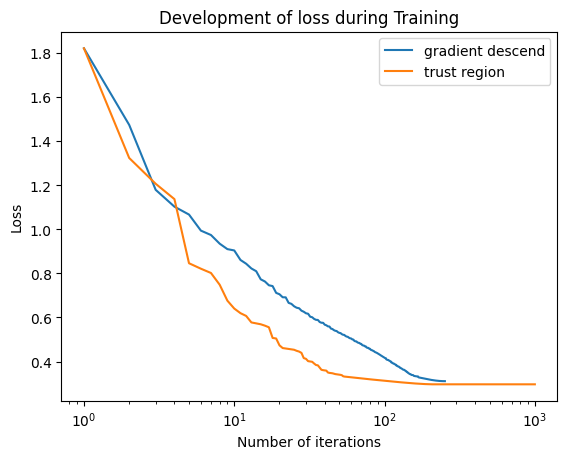

In [16]:
MAX_EPOCH = 1000
ARMIJO_RHO = 0.5
ARMIJO_ALPHA = 0.4
ARMIJO_C = 1e-3
LAMBDA = 1e-2

X, y = datasets.load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=42)

INITIAL_TRUST_RADIUS = 1.0
MAX_TRUST_RADIUS = 100.0
ETA1 = 0.1
ETA2 = 0.8
GAMMA1 = 0.2
GAMA2 = 0.8
lr1 = MultiClassLogisticRegression(X_train, y_train)
lr1.gradient_descend(X_train, MAX_EPOCH, ARMIJO_ALPHA, ARMIJO_RHO, ARMIJO_C, LAMBDA)

lr2 = MultiClassLogisticRegression(X_train, y_train)
lr2.trust_region(X_train, INITIAL_TRUST_RADIUS, MAX_TRUST_RADIUS, MAX_EPOCH, ETA1, ETA2, GAMMA1, GAMA2, LAMBDA)
plot(lr1.loss, lr2.loss)


In [17]:
sklearn_lg = linear_model.LogisticRegression("l2", max_iter=MAX_EPOCH)
sklearn_lg.fit(X_train, y_train)

print(lr1.score(X_test, y_test), sklearn_lg.score(X_test, y_test))
print(lr2.score(X_test, y_test), sklearn_lg.score(X_test, y_test))


0.9523809523809523 0.9619047619047619
0.9523809523809523 0.9619047619047619


Convergence reached. Stopping optimization with 55 iterations
0 18.40546332862519
1 17.83965913476553
2 17.217301892010497
3 16.581483337136973
4 15.925443217065013
5 15.248577824365656
6 14.425125107298022
7 13.653696825573395
8 12.6966467556543
9 11.678369475018371
10 10.871339517804742
11 10.036404914352074
12 9.339764363649426
13 8.718664098919811
14 8.16214228237722
15 7.67818524508627
16 7.0966627349303195
17 6.610941993391203
18 6.273891427745164
19 5.918646756636008
20 5.692135500361159
21 5.452670549185203
22 5.07513690877871
23 4.612129019057369
24 4.272593676312329
25 3.989100882757802
26 3.815235623966442
27 3.554672094049193
28 3.3611154549629436
29 3.1449814774208456
30 2.972395944354333
31 2.825863224346056
32 2.7365497067809734
33 2.6583100842592438
34 2.600834651335602
35 2.5478409442702294
36 2.4981046413820267
37 2.37807581407227
38 2.3204925575795796
39 2.228584969925007
40 2.2013939570744894
41 2.176096775246269
42 2.1521431804831366
43 2.1292329351884365
44 2.1071

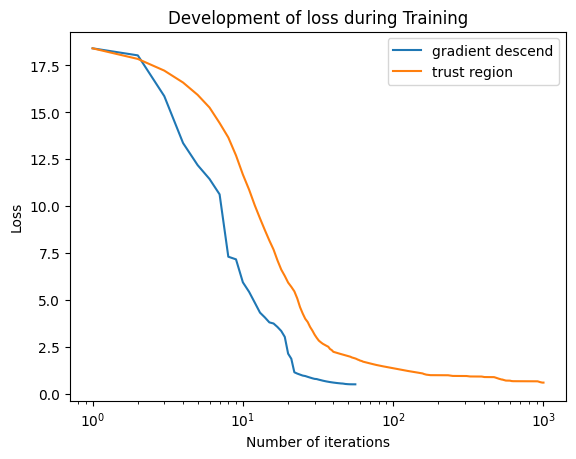

In [18]:
MAX_EPOCH = 1000
ARMIJO_RHO = 0.5
ARMIJO_ALPHA = 0.2
ARMIJO_C = 1e-4
LAMBDA = 1e-2

X, y = datasets.load_digits(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=42)

INITIAL_TRUST_RADIUS = 1.0
MAX_TRUST_RADIUS = 100.0
ETA1 = 0.2
ETA2 = 0.8
GAMMA1 = 0.2
GAMA2 = 0.8
lr1 = MultiClassLogisticRegression(X_train, y_train)
lr1.gradient_descend(X_train, MAX_EPOCH, ARMIJO_ALPHA, ARMIJO_RHO, ARMIJO_C, LAMBDA)

lr2 = MultiClassLogisticRegression(X_train, y_train)
lr2.trust_region(X_train, INITIAL_TRUST_RADIUS, MAX_TRUST_RADIUS, MAX_EPOCH, ETA1, ETA2, GAMMA1, GAMA2, LAMBDA)

plot(lr1.loss, lr2.loss)

In [19]:
sklearn_lg = linear_model.LogisticRegression("l2", max_iter=10000)
sklearn_lg.fit(X_train, y_train)

print(lr1.score(X_test, y_test), sklearn_lg.score(X_test, y_test))
print(lr2.score(X_test, y_test), sklearn_lg.score(X_test, y_test))


0.9030206677265501 0.9459459459459459
0.8521462639109698 0.9459459459459459


Convergence reached. Stopping optimization with 17 iterations
0 2.702935049007303
1 2.5708160779415277
2 2.4495917777749954
3 2.3375500321791813
4 2.2334667387456175
5 2.1364324708591598
6 2.0457420389684557
7 1.9608260338701222
8 1.881208632158739
9 1.8064813307455545
10 1.7362862459873512
11 1.6703051744555122
12 1.608252167654756
13 1.5498682921613427
14 1.4949177847516204
15 1.4431851266371227
16 1.3944727450358252
17 1.3485991585187698
18 1.3053974469172591
19 1.2647139658295314
20 1.226407250686401
21 1.1903470718607165
22 1.1564136136129801
23 1.1264036760383271
24 1.1004877510760354
25 1.0800151536941387
26 1.0609766643816678
27 1.0428003431567432
28 1.0271862942916372
29 1.0148930141629064
30 1.0040536071572044
31 1.0040536071572044
32 1.0040536071572044
33 1.0040536071572044
34 1.0040536071572044
35 1.0040536071572044
36 1.0040536071572044
37 1.0040536071572044
38 1.0040536071572044
39 1.0040536071572044
40 1.0040536071572044
41 1.0040536071572044
42 1.0040536071572044
43 1.0

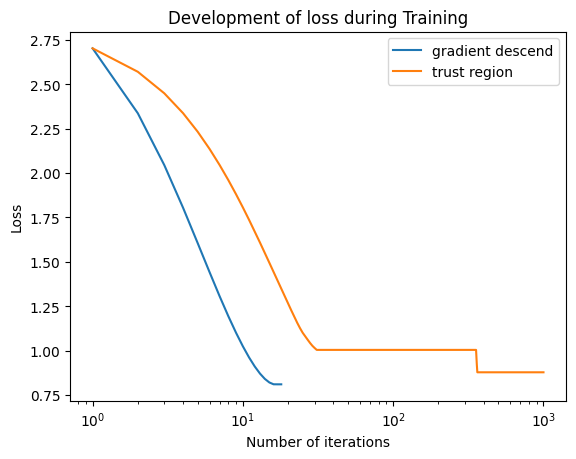

In [20]:
MAX_EPOCH = 1000
ARMIJO_RHO = 0.5
ARMIJO_ALPHA = 0.5
ARMIJO_C = 1e-4
LAMBDA = 0.01
X_train, y_train = read_file('datasets/dna/dna_train.txt', 180)
X_test, y_test = read_file('datasets/dna/dna_test.txt', 180)

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

INITIAL_TRUST_RADIUS = 1.0
MAX_TRUST_RADIUS = 100.0
ETA1 = 0.2
ETA2 = 0.8
GAMMA1 = 0.2
GAMA2 = 0.8
lr1 = MultiClassLogisticRegression(X_train, y_train)
lr1.gradient_descend(X_train, MAX_EPOCH, ARMIJO_ALPHA, ARMIJO_RHO, ARMIJO_C, LAMBDA)

lr2 = MultiClassLogisticRegression(X_train, y_train)
lr2.trust_region(X_train, INITIAL_TRUST_RADIUS, MAX_TRUST_RADIUS, MAX_EPOCH, ETA1, ETA2, GAMMA1, GAMA2, LAMBDA)

plot(lr1.loss, lr2.loss)

In [21]:
sklearn_lg = linear_model.LogisticRegression("l2", max_iter=MAX_EPOCH)
sklearn_lg.fit(X_train, y_train)

print(lr1.score(X_test, y_test), sklearn_lg.score(X_test, y_test))
print(lr2.score(X_test, y_test), sklearn_lg.score(X_test, y_test))

0.7335581787521079 0.9418212478920742
0.6753794266441822 0.9418212478920742


Convergence reached. Stopping optimization with 26 iterations
0 1.8702151441254127
1 1.5588943000281148
2 1.342681019809943
3 1.190100532245611
4 1.076309468972804
5 0.9868597269464698
6 0.9141092706854342
7 0.8540343568547875
8 0.8043597820811019
9 0.7636116830213797
10 0.730695711152171
11 0.7047412652794809
12 0.6850653909286573
13 0.6711818152010649
14 0.6711818152010649
15 0.6711818152010649
16 0.6711818152010649
17 0.6711818152010649
18 0.6711818152010649
19 0.6711818152010649
20 0.6711818152010649
21 0.6711818152010649
22 0.6711818152010649
23 0.6711818152010649
24 0.6711818152010649
25 0.6711818152010649
26 0.6711818152010649
27 0.6711818152010649
28 0.6711818152010649
29 0.6711818152010649
30 0.6711818152010649
31 0.6711818152010649
32 0.6711818152010649
33 0.6711818152010649
34 0.6711818152010649
35 0.6711818152010649
36 0.6711818152010649
37 0.6711818152010649
38 0.6711818152010649
39 0.6711818152010649
40 0.6711818152010649
41 0.6711818152010649
42 0.6711818152010649
43 0.6

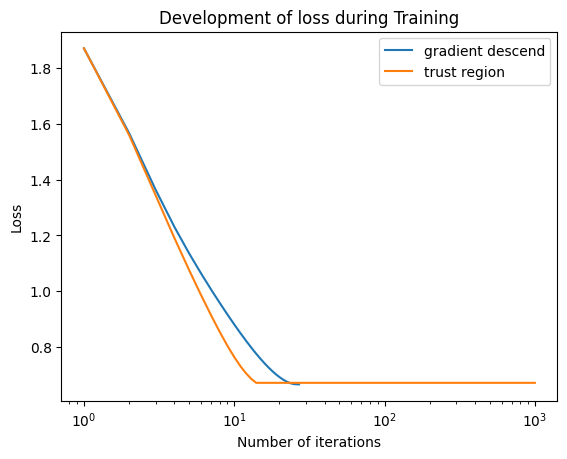

In [22]:
MAX_EPOCH = 1000
ARMIJO_RHO = 0.5
ARMIJO_ALPHA = 0.4
ARMIJO_C = 1e-4
LAMBDA = 0.01

X_train, y_train = read_file('datasets/segment/segment_train.txt', 36)
X_test, y_test = read_file('datasets/segment/segment_test.txt', 36)

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

INITIAL_TRUST_RADIUS = 1.0
MAX_TRUST_RADIUS = 100.0
ETA1 = 0.25
ETA2 = 0.75
GAMMA1 = 0.25
GAMA2 = 0.5
lr1 = MultiClassLogisticRegression(X_train, y_train)
lr1.gradient_descend(X_train, MAX_EPOCH, ARMIJO_ALPHA, ARMIJO_RHO, ARMIJO_C, LAMBDA)

lr2 = MultiClassLogisticRegression(X_train, y_train)
lr2.trust_region(X_train, INITIAL_TRUST_RADIUS, MAX_TRUST_RADIUS, MAX_EPOCH, ETA1, ETA2, GAMMA1, GAMA2, LAMBDA)

plot(lr1.loss, lr2.loss)

In [23]:
sklearn_lg = linear_model.LogisticRegression("l2", max_iter=MAX_EPOCH)
sklearn_lg.fit(X_train, y_train)
print(lr1.score(X_test, y_test), sklearn_lg.score(X_test, y_test))
print(lr2.score(X_test, y_test), sklearn_lg.score(X_test, y_test))

0.7331066723331917 0.7879303017424565
0.7420314492137696 0.7879303017424565
